# SC3000/CZ3005 Assignment 1 - Balancing a Pole on a Cart

Submission Deadline: 11:59 PM, 5 April 2024

Made in Google Colab using Jupyter Notebook File so as to utilise Google's Resources and Computational Power to overcome personal device computational limitations and device specific lack of required libraries. (Devices like Macbooks and certain Windows Computers are unable to run many computationally intensive files due to software and hardware limitations)

# Note on Running File: (IMPORTANT)
If you are unable to run this file in your jupyter notebook environment, please upload this file to Google Colab and run it there after connecting to Google's Resources (RAM and Disk).

## Group Members and Contributions:

1. Bryan Toh Wee Sheng:
- Researched and compared the PPO Model to the other models such as Monte Carlo, Q-Learning and DQN
- Helped with implementation of PPO Model
- Help test code

2. Lim Shaojun (U2221218F):
- Researched and compared the PPO Model to the other models such as Monte Carlo, Q-Learning and DQN
- Helped with implementation of PPO Model
- Formatted Notebook to make it look cleaner

3. Keith Lim En Kai (U2220506C):
- Researched and compared the PPO Model to the other models such as Monte Carlo, Q-Learning and DQN
- Helped with implementation of PPO Model
- Tested Code multiple times to make sure it runs smoothly


# 1. Problem description: (Taken from Assignment Document)
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on thecart and the goal is to balance the pole by applying forces in the left and right direction on the cart. In this project, you will need to develop a Reinforcement Learning (RL) agent. The trained agent makes the decision to push the cart to the left or right based on the cart position, velocity, and the pole angle, angular velocity. (4 parameters)

![Alternative Text](https://www.gymlibrary.dev/_images/cart_pole.gif)

## 1.1 Problem Instance
You are given an instance of the cart pole environment implemented by the gym library. As with any good solution to a problem, we start with

### Action Space:
The action is an nd array with shape (1, which can take values {0,1} indicating actions pushing the cart to the left or right respectively. Note that the velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it.

### Observation Space:
The observation is an nd array with shape (4,) with the values corresponding to the following positions and velocities:

| Num | Observation | Min | Max |
|---|---|---|---|
| 1 | Cart Position | -4.8 | 4.8 |
| 2 | Cart Velocity | -inf | inf |
| 3 | Pole Angle | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
| 4 | Pole Angular Velocity | -inf | inf |

### Reward:
Since the goal is to keep the pole upright for as long as possible, a reward of +1 for every step taken, including the termination step, is allotted.

### Starting State:
All observations are assigned a uniformly random value in **(-0.05, 0.05)**

### Episode End:
The episode ends if any one of the following occurs:
1. Termination: Pole Angle is greater than +/- 12 Degrees == 0.209 rad
2. Termination: Cart Position is greater than +/- 2.4 (center of the cart reaches the edge of the display)
3. Truncation: Episode length is greater than 500.

# 2. Requirements and Guidelines


## Installing Required Libraries and Dependencies:


In [195]:
!pip install stable_baselines3
!pip install shimmy

import gym
from gym.wrappers import RecordVideo
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt
import torch
import glob
from IPython.display import HTML
from IPython import display as ipythondisplay
import io
import base64

def show_video():
    ipythondisplay.clear_output(wait=True)
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                     loop controls style="height: 400px;">
                     <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                     </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

### Loading Cartpole Environment: (Mini Tutorial taken from example code)

In [196]:
env = gym.make("CartPole-v1")

# Taking a look at the action space
print(env.action_space)

# Taking a look at the observation space
print(env.observation_space)

Discrete(2)
Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


Based on the action_space, Discrete(2) means that there are 2 valid discrete actions: 0 and 1. Where 0 represents left while 1 represents right.

Based on the observation_space, the first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [197]:
# We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state,
# e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.
observation = env.reset()

# Taking a look at the initial observations:
print("Initial Observations: ", observation)

Initial Observations:  [ 0.01880994 -0.02000807  0.02592086 -0.04148376]


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [198]:
observation, reward, done, info = env.step(0)[:4]
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [ 0.01840977 -0.21549195  0.02509119  0.25926343]
Reward for this step: 1.0
Is this round done? False


### Example of Game Run using Naive Strategy:
Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [199]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)[:4]
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 8.0


## 2.1 Tasks and Marking Criteria
Now that we have taken a look at how the cartpole game works, we can begin to start using Reinforcement Learning Agents to tackle it.

### Task 1: Development of an Reinforcement Learning (RL) Agent. (30 Marks)
Demonstrate the correctness of the implementation by sampling a random state from the cart pole environment, inputting to the agent, and outputting a chosen action. Print the values of the state and chosen action in the Jupyter Notebook.


# Research

After extensive researching and comparing various reinforcement learning agents such as Monte Carlo, Q-Learning from the Lectures and Deep Q-Learning and Proximal Policy Optimization from our findings, we have decided to go with Proximal Policy Optimization (PPO) as we believe it provides the most stable and simple whilst also being the most sample efficient due the simple nature of the cartpole enviroment.

Due to time constraints, we could not explore every single Reinforcement Learning Agent out there, so there may more efficient or better ways to tackle the cartpole problem and we want to recognize that.

With that out of the way, let us dive into the implementation.

---


# PPO (Proximal Policy Optimization)
## What is PPO?

Proximal policy optimization (PPO) is an algorithm in the field of reinforcement learning that trains a computer agent's decision function to accomplish difficult tasks.

## How it Works

PPO is classified as a **policy gradient method** for training an agent's policy network. The policy network is the function that the agent uses to make decisions. Essentially, to train the right policy network, PPO takes a small policy update (step size), so the agent can reliably reach the optimal solution. A too-big step may direct policy in the false direction, thus having little possibility of recovery; a too-small step lowers overall efficiency. Consequently, PPO implements a clip function that constrains the policy update of an agent from being too large or too small. - Wikipedia


## PPO Algorithm


![Alternative Text](https://spinningup.openai.com/en/latest/_images/math/e62a8971472597f4b014c2da064f636ffe365ba3.svg)

-- OpenAI

For our implementation of the PPO Model, we will be using OpenAI Baseline's implementation of it. This is imported from the stable_baselines3 library. References to this library and its implementation code will be attached below.

The PPO Agent or Model takes in the following parameters:

1. policy: This specifies the type of policy architecture to be used by the PPO algorithm. Common choices include 'MlpPolicy' for a Multi-Layer Perceptron (MLP) policy network and 'CnnPolicy' for a Convolutional Neural Network (CNN) policy network. In our case, we will be using MLP to train our PPO Agent as specified as 'MlpPolicy' in the first parameter.

2. env: This is the environment in which the agent will interact and learn. The env variable should be an instance of a Gym environment, which represents the simulation or task that the agent will learn to solve. This is represented and passed into the agent as the 2nd parameter as 'env'.

3. verbose: This parameter controls the verbosity of the output during training. Setting verbose=1 means that training progress will be printed to the console, providing information about the training process. By default, verbose is often set to 0 for no output. However, in our case to show the training process we will assign verbose=1.

4. device: This parameter specifies the device on which the computations will be performed. It can be set to "cpu" or "cuda" (if you have an Nvidia GPU installed). Alternatively, setting device="auto" allows Stable Baselines to automatically choose the device based on availability. If a GPU is available, it will use the GPU for computations; otherwise, it will use the CPU. (GPUs are usually more optimal for training RL Agents due to their computational power and ability to parallel process)

A common Multi-Layer Perceptron Model: (Taken from Analytics Vidhya)

![Alternative Text](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/02/ANN-Graph.gif)

In [200]:
class CustomCartPoleEnv(gym.Env):
    def __init__(self):
        super(CustomCartPoleEnv, self).__init__()

        # Create the CartPole environment
        self.env = gym.make('CartPole-v1')

        # Define observation space and action space
        self.observation_space = self.env.observation_space
        self.action_space = self.env.action_space

    def reset(self):
        # Reset the environment
        return self.env.reset()

    def step(self, action):
        # Take a step in the environment
        return self.env.step(action)

    def render(self, mode='human'):
        # Render the environment
        return self.env.render(mode)

    def close(self):
        # Close the environment
        return self.env.close()

# Create an instance of the custom CartPole environment
env = CustomCartPoleEnv()

# Create the model and train using PPO algorithm
model = PPO('MlpPolicy', env, verbose=1, device="auto")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [201]:
# total_timesteps is the number of env.steps(action) being run during training
model.learn(total_timesteps=30000, progress_bar=True)

Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.8     |
|    ep_rew_mean     | 21.8     |
| time/              |          |
|    fps             | 555      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 26.6        |
|    ep_rew_mean          | 26.6        |
| time/                   |             |
|    fps                  | 354         |
|    iterations           | 2           |
|    time_elapsed         | 11          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009057311 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.686      |
|    explained_variance   | -0.00343    |
|    learning_rate        | 0.

In [202]:
# Reset the environment and get initial observation
observation = env.reset()

# Get the action predicted by the model for the current observation
action, _ = model.predict(observation)

# Print the observation space and the action taken
print("Observation space is:", observation)
print("Action taken is:", action)


Observation space is: [-0.00928894  0.0319779   0.0173467   0.04892632]
Action taken is: 0


### Task 2: Demonstrate the effectiveness of the RL Agent (40 Marks)
Run for 100 episodes (reset the enviroment at the beginning of each episode) and plot the cumulative reward against all episodes in the Jupyter Notebook. Print the average reward over the 100 episodes. The average reward should be larger than **195**.

In [203]:
sum_episode_scores = []

# Run 100 episodes
for episode in range(1, 100):
    score = 0  # Initialize reward score for the episode
    obs = env.reset()  # Reset the environment to start a new episode
    done = False  # Flag to indicate whether the episode is complete
    state = 0  # Counter to track the number of steps in the episode

    # Run the episode until termination
    while True:
        action = model.predict(obs)[0]  # Get action from the model
        n_state, reward, done, info = env.step(action)  # Take action in the environment
        # Check if termination conditions are met
        if abs(n_state[0]) > 2.4 or abs(n_state[2]) > 0.209 or state == 500:
            break
        obs = n_state  # Update the observation
        score += reward  # Accumulate the reward
        state += 1  # Increment the step counter

    # Print episode information
    print(f'Episode: {episode}; Score: {score}')

    # Store the score for the episode
    sum_episode_scores.append(score)

# Calculate and print the average score over all episodes
average_score = sum(sum_episode_scores) / len(sum_episode_scores)
print("Average score:", average_score)

# Close the environment
env.close()

Episode: 1; Score: 500.0
Episode: 2; Score: 500.0
Episode: 3; Score: 500.0
Episode: 4; Score: 500.0
Episode: 5; Score: 500.0
Episode: 6; Score: 500.0
Episode: 7; Score: 500.0
Episode: 8; Score: 500.0
Episode: 9; Score: 500.0
Episode: 10; Score: 500.0
Episode: 11; Score: 500.0
Episode: 12; Score: 500.0
Episode: 13; Score: 500.0
Episode: 14; Score: 500.0
Episode: 15; Score: 500.0
Episode: 16; Score: 500.0
Episode: 17; Score: 500.0
Episode: 18; Score: 500.0
Episode: 19; Score: 500.0
Episode: 20; Score: 500.0
Episode: 21; Score: 500.0
Episode: 22; Score: 500.0
Episode: 23; Score: 500.0
Episode: 24; Score: 500.0
Episode: 25; Score: 500.0
Episode: 26; Score: 500.0
Episode: 27; Score: 500.0
Episode: 28; Score: 500.0
Episode: 29; Score: 500.0
Episode: 30; Score: 500.0
Episode: 31; Score: 500.0
Episode: 32; Score: 500.0
Episode: 33; Score: 500.0
Episode: 34; Score: 500.0
Episode: 35; Score: 500.0
Episode: 36; Score: 500.0
Episode: 37; Score: 500.0
Episode: 38; Score: 500.0
Episode: 39; Score: 5

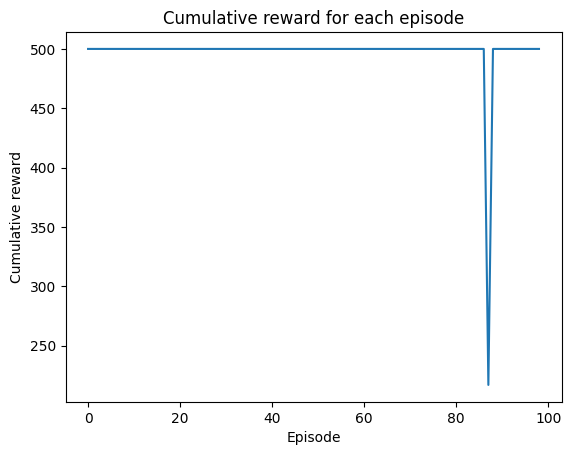

In [204]:
# Plotting the Results of the 100 Episodes over the cumulative reward
plt.plot(sum_episode_scores)
plt.title("Cumulative reward for each episode")
plt.ylabel("Cumulative reward")
plt.xlabel("Episode")

plt.show()

### Task 3: Render one episode played by the developed RL agent on the Jupyter Notebook (10 Marks)

In [205]:
# Record the video of the environment
env = RecordVideo(gym.make("CartPole-v1"), "./video")

# Reset the environment and get initial observation
observation = env.reset()

# Initialize variables to track total score and current state
total_score = 0
current_state = 0

# Loop until the episode terminates
while True:
    # Predict the action using the model
    action = model.predict(observation)[0]

    # Take the predicted action in the environment
    n_state, reward, done, info = env.step(int(action))

    # Check termination conditions
    if abs(n_state[0]) > 2.4 or abs(n_state[2]) > 0.209 or current_state == 500:
        break

    # Update observation, total score, and current state
    observation = n_state
    total_score += reward
    current_state += 1

# Close the environment
env.close()

# Show the recorded video
show_video()

# Print the total score for the episode
print("This Episode's reward is:", total_score)

This Episode's reward is: 500.0


### Task 4: Format the Jupyter Notebook by including step-by-step instructions and explanations, such that the notebook is easy to follow and run (20 Marks)
Include text explanation to demonstrate the originality of your implementation and your understanding of the code. For example, for each task, explain your approach and analyze the output; if you improve an exisiting approach, explain your improvements.

## 2.2 Output Format
All codes are to be included in a single Jupyter notebook written in Python (i.e., .ipynb file).
1.	Include all codes for Task 1-4. Note that the submission is invalid if it only contains the outputs and plots without codes to obtain it.
2.	Run the notebook before submission to save the output in the notebook, i.e., by opening the ipynb file (without running it), one can see the outputs and plots for Task 1-3
3.	Make sure the Jupyter notebook is runnable, i.e., by running each code block sequentially from top to bottom, one can get the results for Task 1-3. The TAs may run your notebook.
4.	Unless you are experienced with Jupyter, it is recommended to modify from the provided Jupyter notebook sample, rather than creating a new one.
5.	If the developed RL agent is a trainable neural network, submit a .zip file by zipping the trained model parameters (e.g., .pth for PyTorch) and the ipynb file. In this case, your notebook must include the training code and model loading code.
6.	Contribution: Please clearly state the contribution of each team member in the beginning of the Jupyter notebook if you have more than one member in your team.

# References:
PPO Definition: https://en.wikipedia.org/wiki/Proximal_policy_optimization

PPO Algorithm: https://spinningup.openai.com/en/latest/algorithms/ppo.html

Multilayer Perceptron Model: https://www.analyticsvidhya.com/blog/2020/12/mlp-multilayer-perceptron-simple-overview/

OpenAI Baselines: https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html

PPO Implementation from stable-baseline3 Code: https://github.com/DLR-RM/stable-baselines3/tree/master/stable_baselines3/ppo